In [16]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt

In [17]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")

In [18]:
with open('../../filelists/hgg_files.txt', 'r') as f:
    hgg_files = [line.strip() for line in f]

In [19]:
hgg = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/signal/hgg/' + hgg_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hgg"},
).events()

In [20]:
genpart = hgg.GenPart

In [21]:
genpart.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [22]:
index = (genpart.pdgId == 25) & (genpart.hasFlags(['isLastCopy']))

In [23]:
assert ak.all(ak.num(genpart[index],axis=1)==1)
higgses = ak.flatten(genpart[index], axis=1)
assert ak.all(abs(higgses.children.pdgId) == 21)
ak.num(higgses.children.children, axis=2)[108]

<Array [7, 0] type='2 * ?int64'>

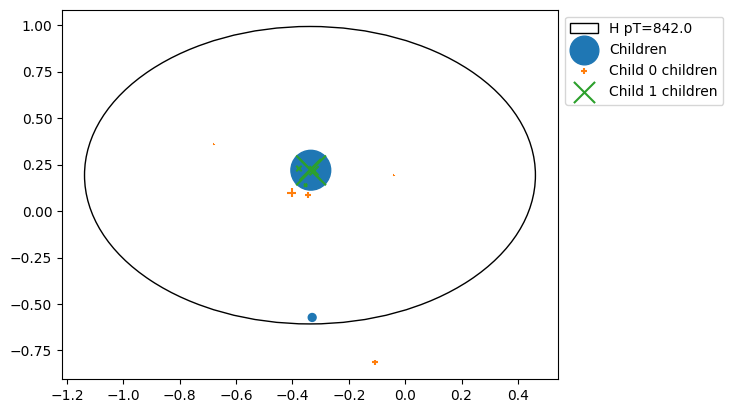

In [53]:
fig,ax = plt.subplots()

higgs = higgses[(higgses.pt>800) & (abs(higgses.phi)<1)][0]
phi0 = higgs.phi
ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label=f"H pT={higgs.pt}"))
ax.scatter(higgs.children.eta, higgs.children.phi, s=higgs.children.pt, label="Children")
ax.scatter(higgs.children[0].children.eta, higgs.children[0].children.phi, s=higgs.children[0].children.pt, marker="+", label="Child 0 children")
ax.scatter(higgs.children[1].children.eta, higgs.children[1].children.phi, s=higgs.children[1].children.pt, marker="x", label="Child 1 children")
ax.legend(bbox_to_anchor=(1,1))

In [25]:
higgses.children.sum().mass

<Array [125, 125, 125, 125, 125, ..., 125, 125, 125, 125] type='3000 * float32'>

In [26]:
ak.all(ak.any(index, axis=1))

True

In [27]:
lastcopyhiggs = ak.where(ak.fill_none(ak.pad_none(index, ak.max(ak.count(index, axis=1))),0)==True)[1]

In [28]:
gluons = ak.unflatten(ak.where(ak.fill_none(ak.pad_none(genpart.genPartIdxMother, ak.max(ak.count(genpart.genPartIdxMother, axis=1))),0) == lastcopyhiggs)[1], counts=2)

In [29]:
gluons

<Array [[12, 13], [10, 11], ..., [10, ...], [9, 10]] type='3000 * 2 * int64'>

In [30]:
genpart.pdgId[0][12:14]

<Array [21, 21] type='2 * int32[parameters={"__doc__": "PDG id"}]'>

In [31]:
firsts = ak.firsts(gluons)
seconds = ak.firsts(ak.sort(gluons, ascending=False))

In [32]:
leading = genpart[firsts]

In [33]:
following = genpart[seconds]

In [34]:
sub1 = ak.where(ak.fill_none(ak.pad_none(genpart.genPartIdxMother, ak.max(ak.count(genpart.genPartIdxMother, axis=1))), 0) == firsts)
sub2 = ak.where(ak.fill_none(ak.pad_none(genpart.genPartIdxMother, ak.max(ak.count(genpart.genPartIdxMother, axis=1))), 0) == seconds)

In [35]:
leading_children = ak.unflatten(sub1[1], counts=np.unique(sub1[0], return_counts=True)[1])
following_children = ak.unflatten(sub2[1], counts=np.unique(sub2[0], return_counts=True)[1])

In [36]:
genpart.pdgId[leading_children]

<Array [[21, 21, 21, 21, ..., 21, 21, 21], ...] type='3000 * var * int32[pa...'>

In [37]:
#genpart.pdgId[following_children]

In [38]:
check = following_children[0:100]

In [39]:
subset = genpart[0:100]

In [40]:
particles = subset.pdgId[check]

In [41]:
for i in range(92,100):
    if len(ak.where(particles[i] != 21)[0]) == 0:
        continue
    else:
        look = ak.where(particles[i] != 21)
        print(i)
        break


In [42]:
particles[17]

<Array [2, 21, 21, -2, 111] type='5 * int32[parameters={"__doc__": "PDG id"}]'>

In [43]:
particles[38]

<Array [2, 21, -2, 111] type='4 * int32[parameters={"__doc__": "PDG id"}]'>

In [44]:
particles[60]

<Array [2, 21, -2, 111, 111, 111] type='6 * int32[parameters={"__doc__": "P...'>

In [45]:
particles[91]

<Array [-4, 4, 21] type='3 * int32[parameters={"__doc__": "PDG id"}]'>